In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.15),  # Dropout after first layer
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.15),  # Dropout after second layer
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.15)   # Dropout after third layer
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 28 * 28, 256),
            nn.Dropout(0.25),  # Dropout before first fully connected layer
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.Dropout(0.25),  # Dropout before second fully connected layer
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x.squeeze()


In [3]:
model = CNN()
criteria = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),0.001, weight_decay=1e-5)
model

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.15, inplace=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.15, inplace=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.15, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(

In [4]:
def acc(base,pred):
    correct = torch.eq(base,pred).sum().item()
    result = (correct/len(pred))*100
    return result

In [5]:
from PIL import Image
import os

path = "/home/emre2020/Downloads/project_nlp/train/"

# Iterate over all files in your dataset
for subdir, dirs, files in os.walk(path):
    for file in files:
        file_path = os.path.join(subdir, file)
        try:
            # Try to open the image
            img = Image.open(file_path)
        except:
            # If an error occurs, print the file name
            print(f"Cannot open image: {file_path}")

/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [6]:
def find_mean_std(dataloader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    
    for data, _ in dataloader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples

    return mean, std

In [7]:

path = "/home/emre2020/Downloads/project_nlp/train/"

# Mean:([0.4883, 0.4553, 0.4171]), STD: ([0.2255, 0.2209, 0.2212])

mean = [0.4883, 0.4553, 0.4171]
std = [0.2255, 0.2209, 0.2212]

# Define your transformations - you can add more augmentations here
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
])

dataset = torchvision.datasets.ImageFolder(path,transform)

# Define the split for train and test - adjust depending on your split
train_size = int(0.80 * len(dataset))
test_size = len(dataset) - train_size

# Split the datasets
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 32 
train_loader =DataLoader(train_dataset, batch_size=batch_size, shuffle=True,)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
def train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs):

    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            labels = labels.squeeze()  
            loss = loss_function(outputs, labels.float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (torch.sigmoid(outputs) >= 0.5).float()
            train_correct += (predicted == labels).float().sum().item()

        train_loss /= len(train_loader)
        train_acc = train_correct / len(train_loader.dataset)

        # Evaluate on the validation set
        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                labels = labels.squeeze()
                loss = loss_function(outputs, labels.float())

                val_loss += loss.item()
                predicted = (torch.sigmoid(outputs) >= 0.5).float()
                val_correct += (predicted == labels).float().sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return model


In [11]:
num_epochs = 30

model = train_model(model, train_loader, test_loader, criteria, optimizer, num_epochs)


Epoch 1/30, Train Loss: 0.6068, Train Acc: 0.6638, Val Loss: 0.5552, Val Acc: 0.7116
Epoch 2/30, Train Loss: 0.5561, Train Acc: 0.7155, Val Loss: 0.5268, Val Acc: 0.7398
Epoch 3/30, Train Loss: 0.5280, Train Acc: 0.7404, Val Loss: 0.5155, Val Acc: 0.7412
Epoch 4/30, Train Loss: 0.5058, Train Acc: 0.7565, Val Loss: 0.4634, Val Acc: 0.7710
Epoch 5/30, Train Loss: 0.4771, Train Acc: 0.7708, Val Loss: 0.5418, Val Acc: 0.7170
Epoch 6/30, Train Loss: 0.4506, Train Acc: 0.7929, Val Loss: 0.4173, Val Acc: 0.8070
Epoch 7/30, Train Loss: 0.4248, Train Acc: 0.8095, Val Loss: 0.4931, Val Acc: 0.7676
Epoch 8/30, Train Loss: 0.4042, Train Acc: 0.8210, Val Loss: 0.3820, Val Acc: 0.8226
Epoch 9/30, Train Loss: 0.3895, Train Acc: 0.8306, Val Loss: 0.3843, Val Acc: 0.8256
Epoch 10/30, Train Loss: 0.3706, Train Acc: 0.8377, Val Loss: 0.3878, Val Acc: 0.8362
Epoch 11/30, Train Loss: 0.3570, Train Acc: 0.8452, Val Loss: 0.3495, Val Acc: 0.8426
Epoch 12/30, Train Loss: 0.3438, Train Acc: 0.8550, Val Loss: 0

In [12]:
torch.save(model,"final_dog_model")

In [17]:
model.eval()
import pandas as pd

In [203]:
def show(path):
    
    img = Image.open(path)
    # Display the image
    plt.imshow(img)
    plt.show()

    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0).to(device)

    # Pass image through the model
    pred = torch.round(torch.sigmoid( model(img_tensor)))

    if pred > 0:
        print(f"It's a Dog with probability { torch.sigmoid( model(img_tensor))} ")
    else:
        print(f"It's a Cat {1 - torch.sigmoid( model(img_tensor))} ")


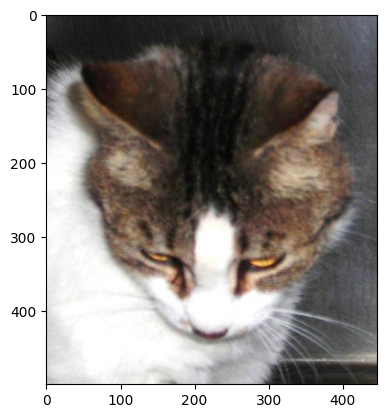

It's a Cat 0.9987573027610779 


In [229]:
show("/home/emre2020/Downloads/project_nlp/dog_test/test1/465.jpg")